In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# I. About the dataset

We use the dataset **Energy balance matrix** from 1970 to 2021 of Brazil. The dataset is downloaded in the website of 
Olade.

The calculations for data processing base on the **Manual Olade 2011**

## I.1 Load the dataset

In [105]:
# Load the file
file_path = '../datas/Option_B/Brazil_Energy balance matrix.xlsx'
#File excel with multi-sheet_names is read as an Dictionary
Dict = pd.read_excel(file_path, sheet_name=None, skiprows=range(4), skipfooter=3)


# Create a new dictionary to store modified dataframes
modified_dict = {}

for k, df in Dict.items():
    # Round the values of each column in the dataframe with 2 decimals
    df = df.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

    # Ignore the first row (unit) in each df
    df = df.iloc[1:]

    # Rename columns in df
    df.rename(columns={'Unnamed: 0': 'SECTOR', 'OTHER PRIMARY_x000d_\n': 'OTHER PRIMARY'}, inplace=True)

    # Remove space in column names and Sector names
    df.columns = df.columns.str.strip()
    df['SECTOR'] = df['SECTOR'].str.strip()

    # Rename in a row
    df['SECTOR'].replace({'COKE PLANTS AND BLAST FURNACES_x000d_': 'COKE PLANTS AND BLAST FURNACES'}, inplace=True)
    
    # fill nule values
    df=df.fillna(np.nan)

    # Convert the keys of Dict to only contain the year
    k_new = k.split(' - ')[0]
    df["YEAR"] = k_new

    # Change all column names to uppercase
    df.columns = df.columns.str.upper()

    # Store the modified dataframe in the new dictionary
    modified_dict[k_new] = df

# Update the original dictionary with the modified dataframes
Dict = modified_dict


print(Dict.keys())

#Save the Clean Dictionary in Excel with multi-sheet_names
file_path='../datas/Option_B/Datas_cleaned/Brazil_Energy balance matrix_cleaned.xlsx'
    
with pd.ExcelWriter(file_path) as writer:
    for k, df in Dict.items():
        df.to_excel(writer, sheet_name=k)



dict_keys(['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'])


## I.2 Frist visualization of energy balance (Supply-Transformation-Adjustment-Consumption)

In [106]:
# Concatenate the data
for k in Dict.keys():    
     # Concatenate all DataFrames in Dict vertically
    df_concat = pd.concat(Dict.values(), ignore_index=True)
    df_concat.set_index("YEAR", inplace=True)
    df_concat.index = df_concat.index.astype(int)
    #df_concat.index = pd.to_datetime(df_concat.index, format='%Y')
    
df_concat.head()

,SECTOR,OIL,NATURAL GAS,COAL,HYDROENERGY,GEOTHERMAL,NUCLEAR,FIREWOOD,SUGARCANE AND PRODUCTS,OTHER PRIMARY,...,KEROSENE/JET FUEL,DIESEL OIL,FUEL OIL,COKE,CHARCOAL,GASES,OTHER SECONDARY,NON-ENERGY,TOTAL SECUNDARIES,TOTAL
YEAR,,,,,,,,,,,,,,,,,,,,,
1970,PRODUCTION,8161.58,1102.24,1044.43,3421.52,NaN,NaN,31851.53,3600.7,223.24,...,1307.21,5674.61,8399.23,55.18,1766.75,465.95,321.73,886.77,31068.07,49405.24
1970,IMPORT,17845.05,NaN,1358.47,NaN,NaN,NaN,NaN,NaN,NaN,...,8.19,NaN,NaN,72.42,NaN,NaN,NaN,368.92,937.48,20141.01
1970,EXPORT,65.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,122.91,47.15,748.34,NaN,NaN,NaN,NaN,NaN,920.12,985.17
1970,STOCK CHANGE,-277.33,NaN,-167.52,NaN,NaN,NaN,NaN,NaN,NaN,...,-54.86,-42.01,-69.03,-24.83,NaN,NaN,15.41,-53.93,-345.28,-790.13
1970,UNUSED,NaN,922.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,55.88,50.45,NaN,106.33,1028.54


### Show the data summary over years

In [107]:
# Group by Year and SECTOR, and sum the TOTAL values
selected_SECTORS=['TOTAL SUPPLY','TOTAL TRANSFORMATION','ADJUSTMENT','FINAL CONSUMPTION']
df_summary=df_concat.copy()

#df_summary=df_summary.apply(lambda column: column.fillna(0))
df_summary=df_summary[df_summary['SECTOR'].isin(selected_SECTORS)]
df_summary = df_summary.groupby(['YEAR','SECTOR'])['TOTAL'].sum().reset_index()
# Pivot the data
df_summary = df_summary.pivot(index='YEAR', columns='SECTOR', values='TOTAL')

# Reorder the columns in df
df_summary = df_summary[selected_SECTORS]

# Display the resultdf_summary
df_summary.head()

SECTOR,TOTAL SUPPLY,TOTAL TRANSFORMATION,ADJUSTMENT,FINAL CONSUMPTION
YEAR,,,,
1970,66742.40,-5422.47,1.85,58834.12
1971,70092.03,-5437.72,4.11,61691.69
1972,75111.33,-5936.88,-29.62,65995.12
1973,81963.44,-6488.78,-17.64,71692.86
1974,87628.20,-6959.24,25.71,76198.40


### Visualize the data summary

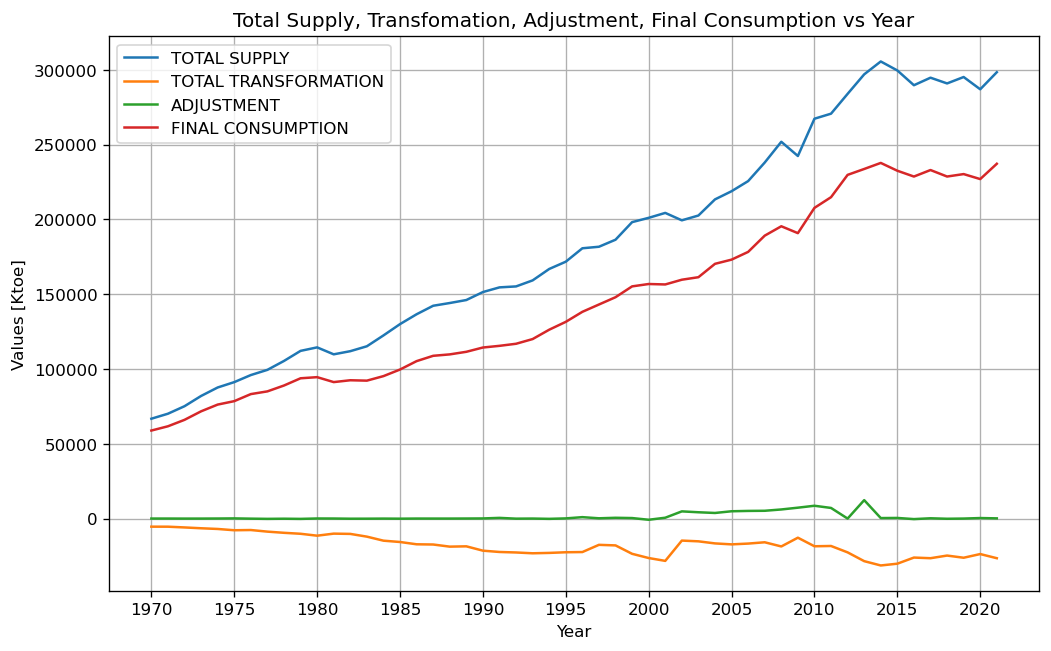

In [108]:
#selected_SECTORS=['TOTAL SUPPLY','TOTAL TRANSFORMATION','ADJUSTMENT','FINAL CONSUMPTION']
# Create a figure and axis
fig, ax = plt.subplots(figsize=( 10,6))

#for k in selected_SECTORS:
 #   df_k=df_concat.loc[df_concat["SECTOR"]==k].drop(columns=["SECTOR"], axis=1)
  #  sns.lineplot(data=df_k, x=df_k.index, y='TOTAL', label=k, ax=ax)

for col in df_summary.columns:
    sns.lineplot(data=df_summary[col], x=df_summary.index, y=df_summary[col], label=col, ax=ax)
        
# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel(f'Values [Ktoe]')
ax.set_title(f'Total Supply, Transfomation, Adjustment, Final Consumption vs Year')
ax.set_xticks(df_summary.index.unique()[::5])

# Show the legend
ax.legend()

# Show the plot
plt.grid(True)
plt.show()




The negative transformation values over  years typically means that more energy was consumed or transformed within the energy system than was produced or input into the system during that specific time period (year). In other words, it indicates an energy deficit or a situation where the energy demands and transformations within the system exceeded the energy available from primary sources or imports.

## I.3 Sankey Diagram

- Sankey diagrams are valuable tools for visualizing energy flows and understanding energy balances in complex systems. 

- Reviewing Sankey diagrams in an energy balance context is crucial for gaining insights into energy flows, identifying inefficiencies, ensuring a balance between supply and demand, and making informed decisions about energy policy, efficiency improvements, and environmental management. They provide a concise and visually intuitive representation of complex energy data, making it easier for stakeholders to understand and act upon energy-related challenges and opportunities.

In [109]:
from collections import defaultdict
import plotly.graph_objects as go

### Define the Plot function

In [110]:
# Defining the Plot function
def Plot(year,db):
    label=db[year]["label"]
    source=db[year]["source"]
    target=db[year]["target"]
    value=db[year]["value"]
    color_nodes=db[year]["color_nodes"]
    color_links=db[year]["color_links"]
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 30,
          thickness = 20,
          line = None, # dict(color = "black", width = 0.5),
          label = label,
          color = color_nodes
        ),
        link = dict(
          source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = target,
          value = value,
            color=color_links
      ))])

    fig.update_layout(title_text=year, font_size=10)
    fig.show()

#### Preparation the data to plot

In [111]:
# Preparation the data to plot
def Data_Generate(Dict):
    
    Dict_out = {}  # Initialize the output dictionary
    for sheet_name in Dict.keys():

        df=Dict[sheet_name]
        
         # Reset index
        df=df.set_index('SECTOR')

        # Transpose df
        df=df.T

        # Fill NaN values
        df=df.fillna(np.nan)
       

        # define the combinations
        Transformers=['REFINERIES', 'POWER PLANTS', 'SELF-PRODUCERS',
               'GAS PLANTS', 'CHARCOAL PLANTS', 'COKE PLANTS AND BLAST FURNACES',
               'DISTILLERIES', 'OTHER CENTERS']
        Primaries=['OIL','NATURAL GAS','COAL','HYDROENERGY','GEOTHERMAL','NUCLEAR','FIREWOOD','SUGARCANE AND PRODUCTS','OTHER PRIMARY']
        Secondaries=['ELECTRICITY','LPG','GASOLINE/ALCOHOL','KEROSENE/JET FUEL','DIESEL OIL','FUEL OIL','COKE','CHARCOAL','GASES','OTHER SECONDARY']
        Consumptions=['TRANSPORT','INDUSTRIAL','RESIDENTIAL','COMMERCIAL, SERVICES, PUBLIC','AGRICULTURE, FISHING AND MINING','CONSTRUCTION AND OTHERS']

        unique_combinations = []

        # here add secondary combination then type of consumption combination

        for i in Transformers:
            for j in Primaries:
                unique_combinations.append((j, i,abs(df[i][j])))

        for i in Transformers:
            for j in Secondaries:
                unique_combinations.append((i, j,abs(df[i][j])))

        # the final consumption column - Usage column
        for i in Consumptions:
            for j in Primaries+Secondaries:
                unique_combinations.append((j, i,abs(df[i][j])))
                
        label=Transformers+Primaries+Secondaries+Consumptions+Primaries+Secondaries
        
        #colors
        color_Transformers=['blue','yellow','green','orange','grey','grey','pink','cyan']
        color_Primaries=['black','orange','darkgray','lightblue','darkred','red','brown','darkgreen','khaki']
        color_Secondaries=['yellow','lightgreen','plum','plum','plum','grey','grey','grey','grey']
        color_Consumptions=['darkmagenta' for i in range(9)]
        color_nodes=color_Transformers+color_Primaries+color_Secondaries+color_Consumptions+color_Primaries+color_Secondaries
        
        # Rename the sheet_name to contain only year. Sample: "1970 - Brazil"--> "1970"
        sheet_name_new = sheet_name.split(' - ')[0]
    
        _dict=Dict_out[sheet_name_new]={}
        _dict["source"]=[]
        _dict["target"]=[]
        _dict["value"]=[]
        _dict["label"]=label
        _dict["color_nodes"]=color_nodes
        _dict["color_links"]=[]
        


        #Dict_out[sheet_name_new] = data  # Store the data in the dictionary
        for k in unique_combinations:
            _dict["source"].append(label.index(k[0]))
            _dict["target"].append(label.index(k[1]))
            _dict["value"].append(k[2])
            _dict["color_links"].append(color_nodes[label.index(k[0])])
    return Dict_out

In [112]:
db=Data_Generate(Dict)

### Sample plot

In [113]:
Plot(year='1980',db=db)

## II. DATA ANALYSIS CONSUMPTION



In [114]:
# Show the df final consumption:
df_C=df_concat.copy()

selected_SECTORS_C=['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS',
       'NON-ENERGY CONSUMPTION','FINAL CONSUMPTION']

df_C=df_C[df_C['SECTOR'].isin(selected_SECTORS_C)]
df_C = df_C.groupby(['YEAR','SECTOR'])['TOTAL'].sum().reset_index()
# Pivot the data
df_C = df_C.pivot(index='YEAR', columns='SECTOR', values='TOTAL')

# Reorder the columns in df
df_C = df_C[selected_SECTORS_C]

# Display the resultdf_summary
df_C.head()

SECTOR,TRANSPORT,INDUSTRIAL,RESIDENTIAL,"COMMERCIAL, SERVICES, PUBLIC","AGRICULTURE, FISHING AND MINING",CONSTRUCTION AND OTHERS,NON-ENERGY CONSUMPTION,FINAL CONSUMPTION
YEAR,,,,,,,,
1970,12661.99,16020.92,22075.66,1266.80,5351.01,0.00,1457.73,58834.12
1971,13841.87,17454.73,22253.96,1406.98,5317.39,0.00,1416.75,61691.69
1972,15633.22,19026.99,22440.87,1570.69,5338.47,0.00,1984.88,65995.12
1973,18328.90,21493.43,22354.13,1737.84,5441.91,0.00,2336.65,71692.86
1974,20105.68,23257.01,22316.70,1873.46,5376.38,7.15,3262.03,76198.40


In [115]:
# df_C_percentages calculate the percentages

df_C_percentages = (df_C.drop(columns=['FINAL CONSUMPTION']).div(df_C['FINAL CONSUMPTION'], axis=0) * 100)
df_C_percentages = df_C_percentages.round(0)

df_C_percentages.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION'],
      dtype='object', name='SECTOR')

In [116]:
# Drop the 'FINAL CONSUMPTION' column (if not already dropped) as it is not needed for the stack plot
df_stackplot = df_C.drop(columns=["FINAL CONSUMPTION"])



### a- Show the line_plot:

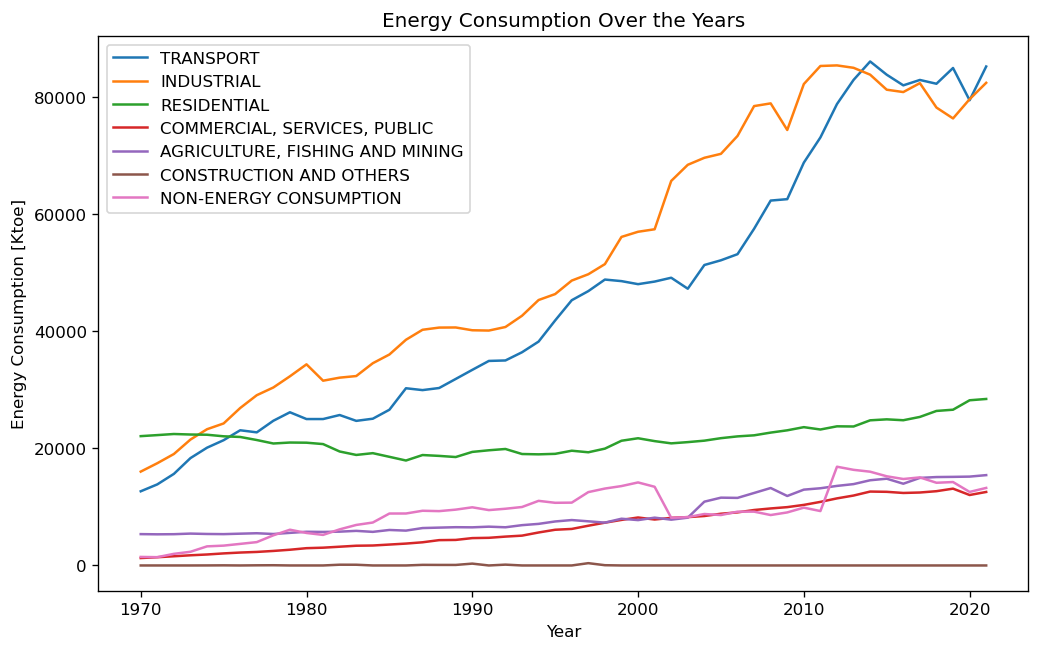

In [117]:
data=df_stackplot.copy()

# Line_Plot:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

data.plot(ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Energy Consumption [Ktoe]')
ax1.set_title('Energy Consumption Over the Years')
ax1.legend(loc='upper left')

plt.show()

### b- Plot both stack plots side by side

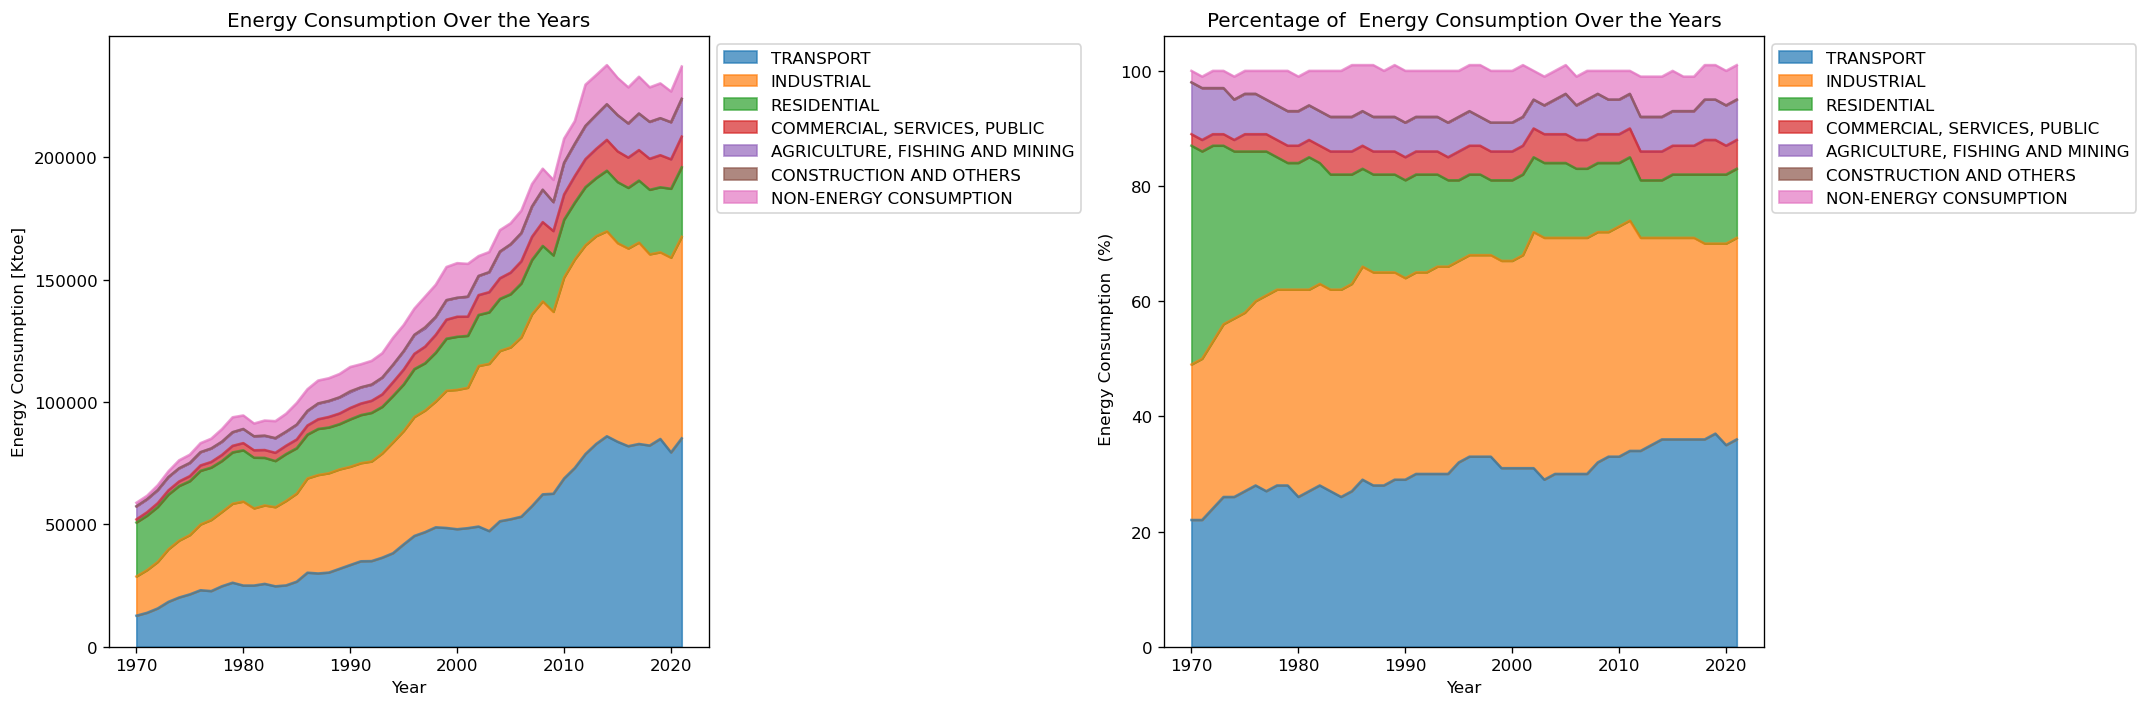

In [118]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6))

df_stackplot.plot.area(stacked=True, alpha=0.7, ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Energy Consumption [Ktoe]')
ax1.set_title('Energy Consumption Over the Years')
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

df_C_percentages.plot.area(stacked=True, alpha=0.7, ax=ax2)

ax2.set_xlabel('Year')
ax2.set_ylabel(' Energy Consumption  (%)')
ax2.set_title('Percentage of  Energy Consumption Over the Years')
ax2.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

### CORRELATION MATRIX

In [119]:
#df_C.index = pd.to_datetime(df_C.index, format='%Y')
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

In [120]:

list_corr=df_C.columns.drop(['FINAL CONSUMPTION'])

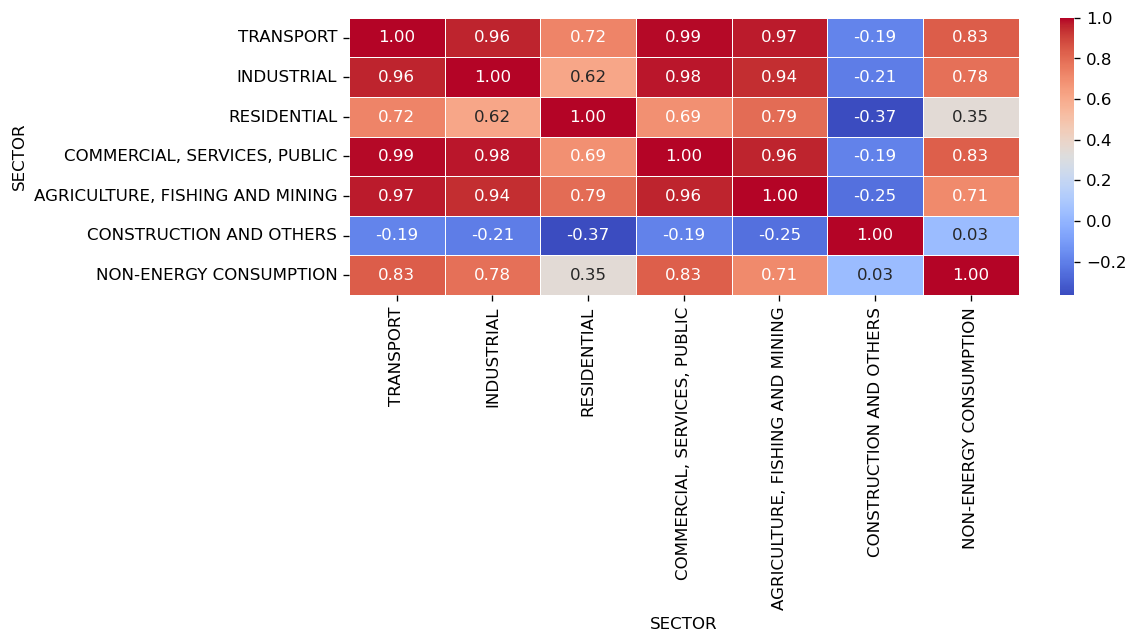

In [121]:

corr_mat = df_C[list_corr].corr()
sns.heatmap(corr_mat,annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.show()

From the correlation matrix, we can observe that the sector **'CONSTRUCTION AND OTHERS'** has a very low correlation with other sectors. We can consider dropping it if necessary.

In [122]:
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

## Scaled data

### MinMaxScaler
<img src="attachment:e9c23a6d-74b4-446c-810b-9ceb0da41f8e.png" width="300">

In [123]:
df_C.head()

SECTOR,TRANSPORT,INDUSTRIAL,RESIDENTIAL,"COMMERCIAL, SERVICES, PUBLIC","AGRICULTURE, FISHING AND MINING",CONSTRUCTION AND OTHERS,NON-ENERGY CONSUMPTION,FINAL CONSUMPTION
YEAR,,,,,,,,
1970,12661.99,16020.92,22075.66,1266.80,5351.01,0.00,1457.73,58834.12
1971,13841.87,17454.73,22253.96,1406.98,5317.39,0.00,1416.75,61691.69
1972,15633.22,19026.99,22440.87,1570.69,5338.47,0.00,1984.88,65995.12
1973,18328.90,21493.43,22354.13,1737.84,5441.91,0.00,2336.65,71692.86
1974,20105.68,23257.01,22316.70,1873.46,5376.38,7.15,3262.03,76198.40


In [124]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_C)
scaled_df = pd.DataFrame(scaled_data, columns=df_C.columns)
scaled_df.set_index(df_C.index, inplace=True)

In [125]:
scaled_df.head()

SECTOR,TRANSPORT,INDUSTRIAL,RESIDENTIAL,"COMMERCIAL, SERVICES, PUBLIC","AGRICULTURE, FISHING AND MINING",CONSTRUCTION AND OTHERS,NON-ENERGY CONSUMPTION,FINAL CONSUMPTION
YEAR,,,,,,,,
1970,0.000000,0.000000,0.395950,0.000000,0.003327,0.000000,0.002654,0.000000
1971,0.016081,0.020678,0.412922,0.011833,0.000000,0.000000,0.000000,0.015970
1972,0.040495,0.043352,0.430713,0.025652,0.002086,0.000000,0.036794,0.040021
1973,0.077235,0.078921,0.422457,0.039761,0.012323,0.000000,0.059575,0.071865
1974,0.101450,0.104355,0.418894,0.051209,0.005838,0.018204,0.119505,0.097046


### Running ARIMA

We apply the ARIMA model to all sectors, but first, we need to perform some checks to select the best parameters **(p, d, q)**

In [77]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score


In [78]:

# Split data into train and test sets 
train_size = int(len(df_C) * 0.80)

# Separate the data into 2 parts: training and validation
data_tr= df_C.iloc[:train_size]
data_val=df_C.iloc[train_size:]


In [79]:
data_tr.tail()

SECTOR,TRANSPORT,INDUSTRIAL,RESIDENTIAL,"COMMERCIAL, SERVICES, PUBLIC","AGRICULTURE, FISHING AND MINING",CONSTRUCTION AND OTHERS,NON-ENERGY CONSUMPTION,FINAL CONSUMPTION
YEAR,,,,,,,,
2006,53138.32,73324.16,22034.81,9060.76,11535.36,0.0,9183.32,178276.74
2007,57478.13,78418.45,22216.18,9467.70,12375.19,0.0,9185.24,189140.88
2008,62289.25,78879.36,22681.60,9732.39,13222.55,0.0,8607.79,195412.94
2009,62530.21,74338.79,23071.27,9958.74,11860.91,0.0,9054.90,190814.83
2010,68765.74,82179.55,23610.56,10339.55,12945.44,0.0,9871.64,207712.48


In [100]:
data_val.tail()

SECTOR,TRANSPORT,INDUSTRIAL,RESIDENTIAL,"COMMERCIAL, SERVICES, PUBLIC","AGRICULTURE, FISHING AND MINING",CONSTRUCTION AND OTHERS,NON-ENERGY CONSUMPTION,FINAL CONSUMPTION
YEAR,,,,,,,,
2017,82878.31,82334.45,25356.57,12453.69,14947.62,0.0,15033.99,233004.63
2018,82229.91,78167.81,26377.98,12678.81,15092.95,0.0,14117.93,228665.38
2019,84921.14,76310.71,26589.02,13113.50,15123.66,0.0,14240.02,230298.05
2020,79414.26,79593.61,28199.70,12027.15,15168.99,0.0,12556.05,226959.77
2021,85176.10,82389.66,28421.75,12548.34,15421.69,0.0,13236.97,237194.52


In [81]:
df_C.columns

Index(['TRANSPORT', 'INDUSTRIAL', 'RESIDENTIAL',
       'COMMERCIAL, SERVICES, PUBLIC', 'AGRICULTURE, FISHING AND MINING',
       'CONSTRUCTION AND OTHERS', 'NON-ENERGY CONSUMPTION',
       'FINAL CONSUMPTION'],
      dtype='object', name='SECTOR')

### II.1. TRANSPORT

In [82]:
df_transport=df_C[['TRANSPORT']]
df_transport.head()

SECTOR,TRANSPORT
YEAR,
1970,12661.99
1971,13841.87
1972,15633.22
1973,18328.90
1974,20105.68


In [83]:
# Train and Test data
df_tr=df_transport.iloc[:train_size]#train[['TRANSPORT']]
df_val=df_transport.iloc[train_size:]

### check stationary of the time series

In [84]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    

In [86]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    In this case, the p-value is almost  1
 , we can conclude that the data is not stationary.

The next step, The Partial Autocorrelation Function (PACF) is visualized.

Showing the PACF is important in time series analysis because it helps in model selection, order determination, diagnosing the adequacy of a chosen model, and understanding the underlying autocorrelation structure of the data.
    return({'mape':mape})




IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [87]:
test_stationarity(df_tr)

Results of Dickey-Fuller Test:
Test Statistic                  1.419910
p-value                         0.997203
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In this case, the p-value is almost  $1$, we can conclude that the data is not stationary.

**The next step, The Partial Autocorrelation Function (PACF) is visualized.**

Showing the PACF is important in time series analysis because it helps in model selection, order determination, diagnosing the adequacy of a chosen model, and understanding the underlying autocorrelation structure of the data. 

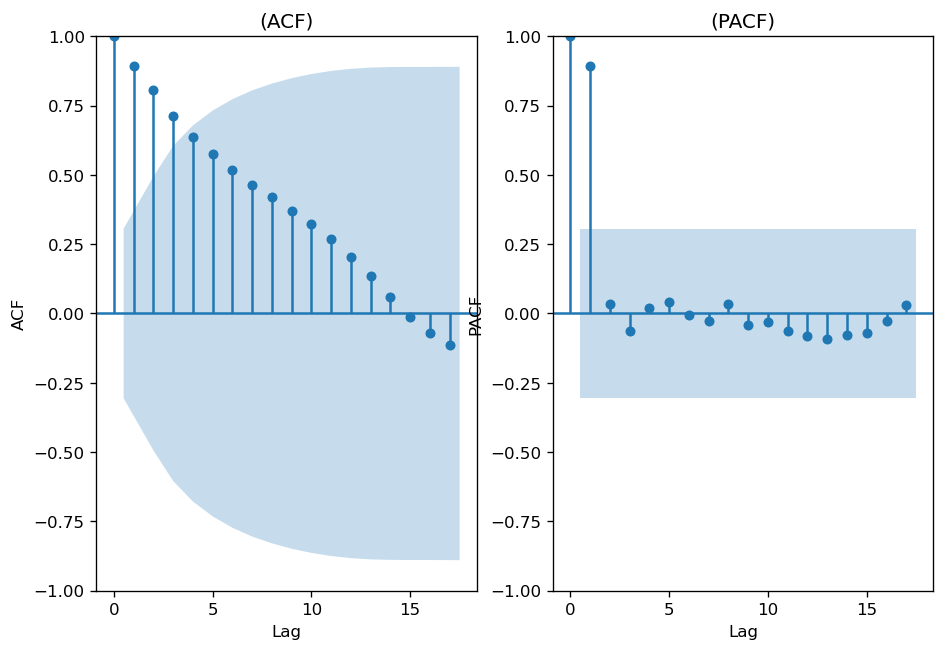

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


#plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

# Plot ACF
plot_acf(df_tr, ax=axes[0])
axes[0].set_title('(ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# Plot PACF
plot_pacf(df_tr, ax=axes[1], method='ywm')
axes[1].set_title('(PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.show()


## How to find the order of differencing (d) in ARIMA model

**Transform to stationary: differencing**

In some cases, we  might need to apply differencing to make a time series stationary. If the autocorrelations (ACF) are positive for many number of lags (10 or more), then the series needs further differencing.


<AxesSubplot:xlabel='YEAR'>

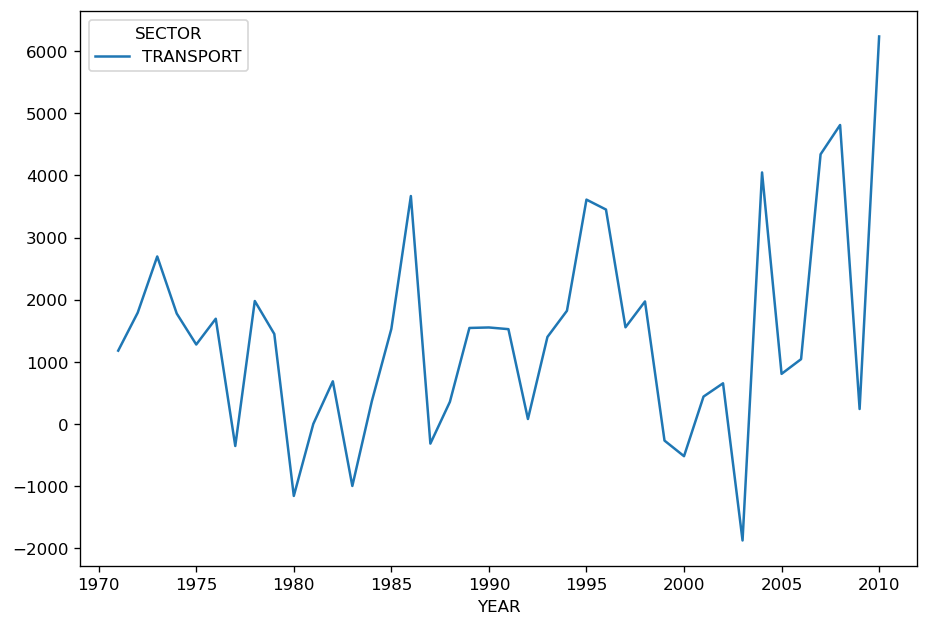

In [89]:
train_diff = df_tr.diff().dropna()
train_diff.plot()

In [90]:
#Test with diffencing data:
test_stationarity(train_diff)


Results of Dickey-Fuller Test:
Test Statistic                 -2.452644
p-value                         0.127426
#Lags Used                      4.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [91]:
# Check the second differential:
train_diff_2=df_tr.diff().diff().dropna()


In [92]:
test_stationarity(train_diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -8.368694e+00
p-value                        2.698869e-13
#Lags Used                     1.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


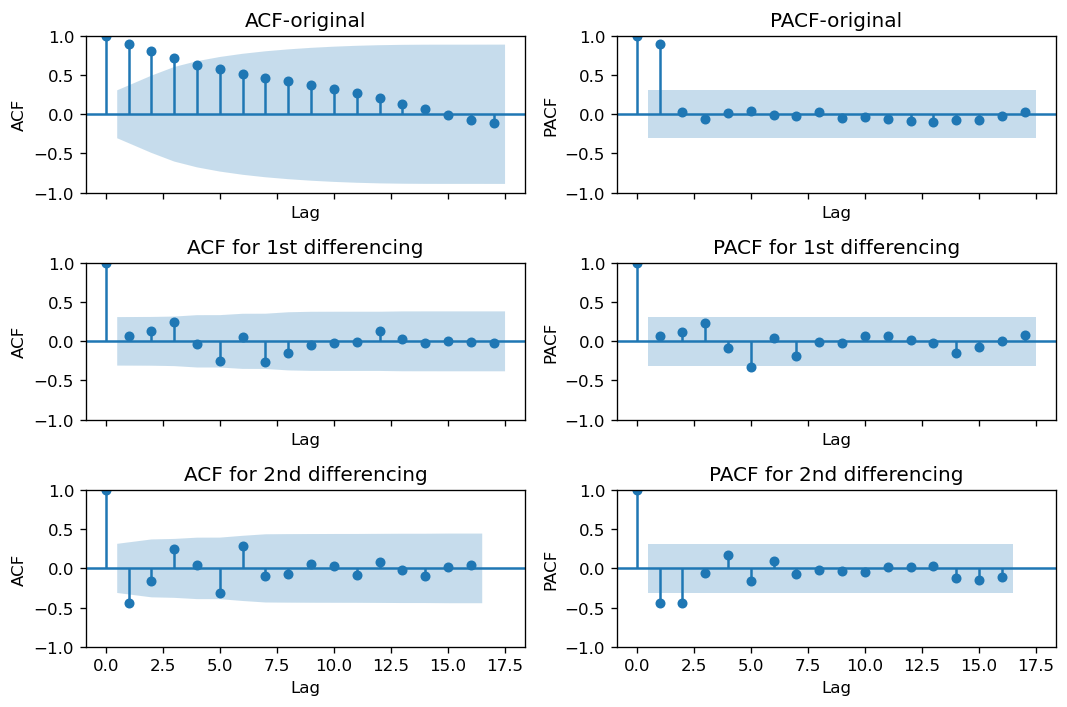

In [93]:

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (9, 6), 'figure.dpi': 120})

fig, axes = plt.subplots(3, 2, sharex=True)

# Plot ACF for original data
plot_acf(df_tr, ax=axes[0, 0])
axes[0, 0].set_title('ACF-original')
axes[0, 0].set_xlabel('Lag')
axes[0, 0].set_ylabel('ACF')

# Plot PACF for train
plot_pacf(df_tr, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('PACF-original')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('PACF')


# Plot ACF for train_diff
plot_acf(train_diff, ax=axes[1, 0])
axes[1, 0].set_title('ACF for 1st differencing')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('ACF')

# Plot PACF for train_diff
plot_pacf(train_diff, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF for 1st differencing')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('PACF')

# Plot ACF for train_diff_2
plot_acf(train_diff_2, ax=axes[2, 0])
axes[2, 0].set_title('ACF for 2nd differencing')
axes[2, 0].set_xlabel('Lag')
axes[2, 0].set_ylabel('ACF')

# Plot PACF for train_diff_2
plot_pacf(train_diff_2, ax=axes[2, 1], method='ywm')
axes[2, 1].set_title('PACF for 2nd differencing')
axes[2, 1].set_xlabel('Lag')
axes[2, 1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

In the second differential, the p-value is small enough to conclude that the series is well stationary  but on looking at the autocorrelation (ACF) plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

In conclusion, we may take $d=1$ or $2$

In [94]:
data_val.index

Int64Index([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype='int64', name='YEAR')

We can observe from the above figures that the best combinations for **(p,d,q)** can be:
**(1,1,1)** or **(3,2,2)**

In [95]:
df_transport.index = pd.to_datetime(df_transport.index, format='%Y')
df_tr.index = pd.to_datetime(df_tr.index, format='%Y')
df_val.index = pd.to_datetime(df_val.index, format='%Y')
df_val.head()

SECTOR,TRANSPORT
YEAR,
2011-01-01,73066.20
2012-01-01,78767.15
2013-01-01,82886.93
2014-01-01,86034.69
2015-01-01,83773.75


                               SARIMAX Results                                
Dep. Variable:              TRANSPORT   No. Observations:                   41
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -354.810
Date:                Sat, 09 Sep 2023   AIC                            715.619
Time:                        00:33:28   BIC                            720.686
Sample:                    01-01-1970   HQIC                           717.451
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    478.514      0.000       0.996       1.004
ma.L1         -0.9985      0.202     -4.946      0.000      -1.394      -0.603
sigma2      2.851e+06   7.01e-08   4.07e+13      0.0

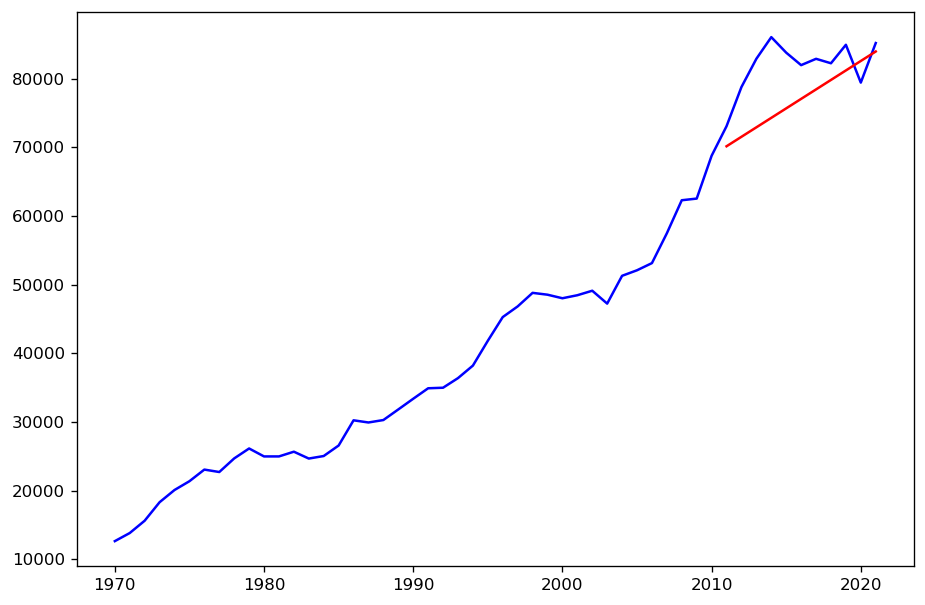

In [96]:
# check with order=(1,1,1)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(1,1,1)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)

# Plot

plt.plot(df_transport, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")


In [97]:
mape = np.mean(np.abs(df_forecast - df_val)/(df_val))



                               SARIMAX Results                                
Dep. Variable:              TRANSPORT   No. Observations:                   41
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -344.412
Date:                Sat, 09 Sep 2023   AIC                            700.825
Time:                        00:59:37   BIC                            710.806
Sample:                    01-01-1970   HQIC                           704.406
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6562      0.313     -5.291      0.000      -2.270      -1.043
ar.L2         -1.3677      0.285     -4.793      0.000      -1.927      -0.808
ar.L3         -0.5342      0.111     -4.813      0.0

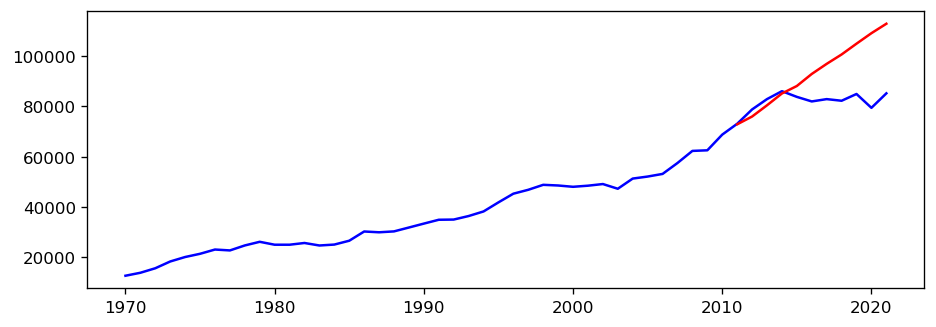

In [129]:
# check with order=(3,2,2)

#fit the arima model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_tr, order=(3,2,2)) #this combination is the best
model_fit = model.fit()
print(model_fit.summary())
# Prediction

# prediction

forecast_val = model_fit.predict(start=df_val.index[0], end=df_val.index[-1])

# Create a Pandas DataFrame with the forecasted values and set the index
df_forecast = pd.DataFrame(data=forecast_val, index=df_val.index)

# Plot

plt.plot(df_transport, "b", label= "Actual")
plt.plot(df_forecast, "r", label="Forecast")



## ARIMA FOR ALL VARIABLES

Variable: INDUSTRIAL
Prueba de estacionariedad:
Results of Dickey-Fuller Test:
Test Statistic                  1.473312
p-value                         0.997423
#Lags Used                      8.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


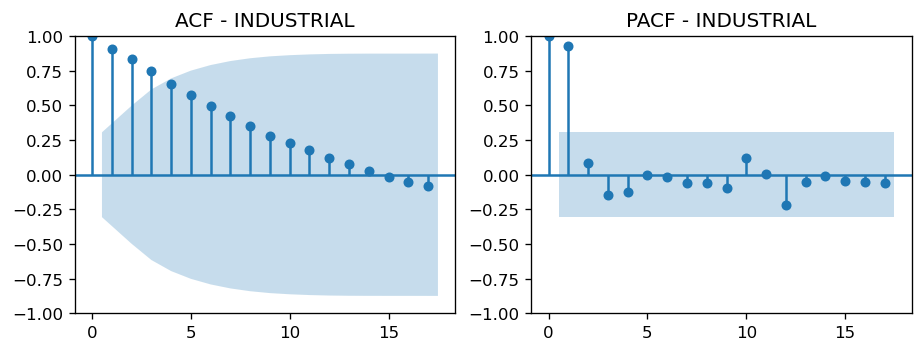

Prueba de estacionariedad con d=0:
Results of Dickey-Fuller Test:
Test Statistic                 -1.004140
p-value                         0.751751
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Prueba de estacionariedad con d=1:
Results of Dickey-Fuller Test:
Test Statistic                -6.254165e+00
p-value                        4.380088e-08
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64
Prueba de estacionariedad con d=2:
Results of Dickey-Fuller Test:
Test Statistic                 -2.965914
p-value                         0.038203
#Lags Used                     11.000000
Number of Observations Used    38.000000
Critical Valu

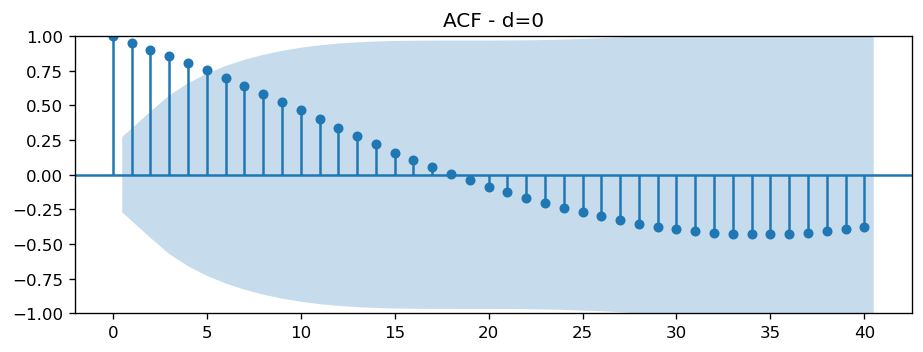

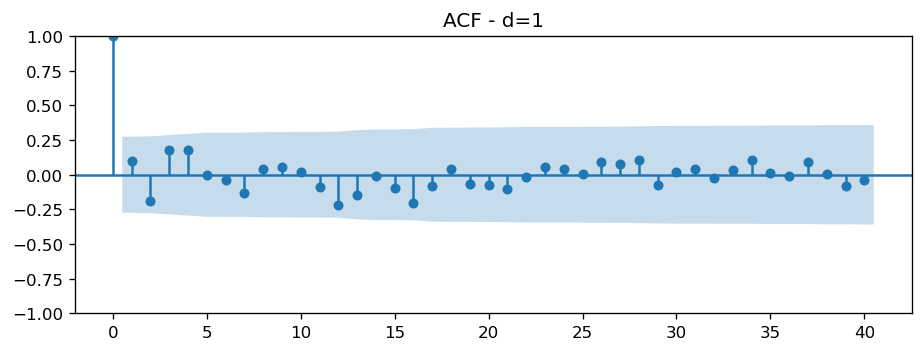

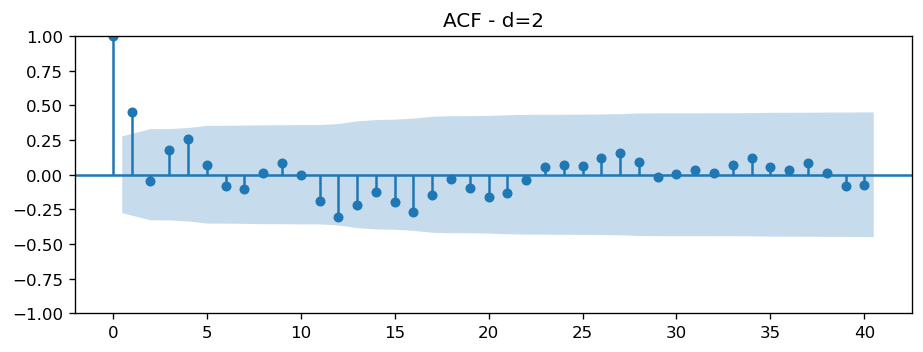

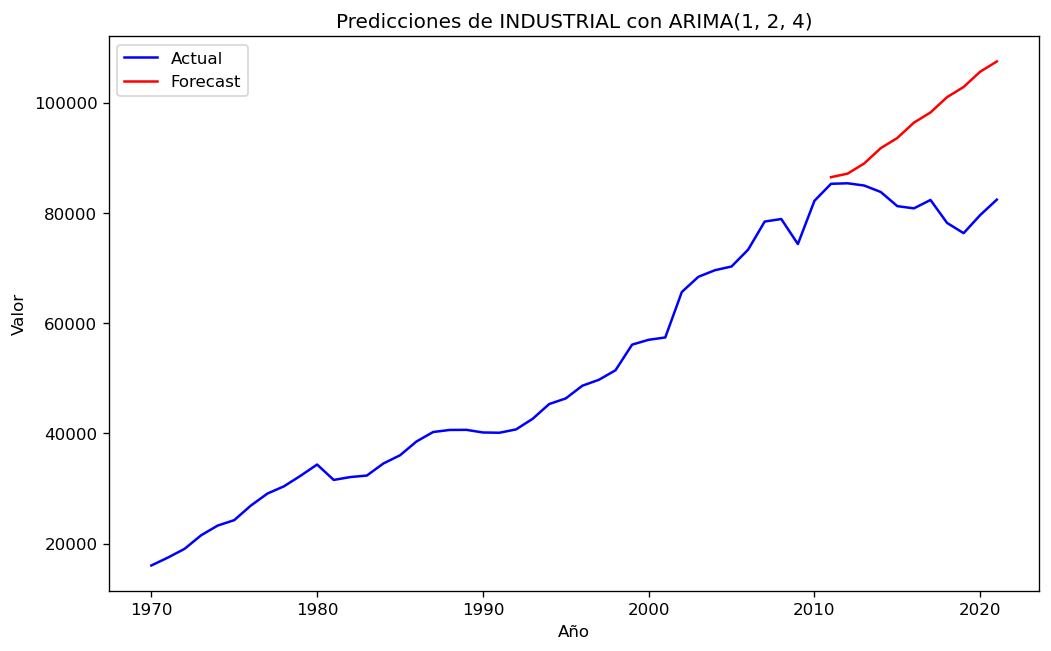



Variable: RESIDENTIAL
Prueba de estacionariedad:
Results of Dickey-Fuller Test:
Test Statistic                 -0.383790
p-value                         0.912770
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


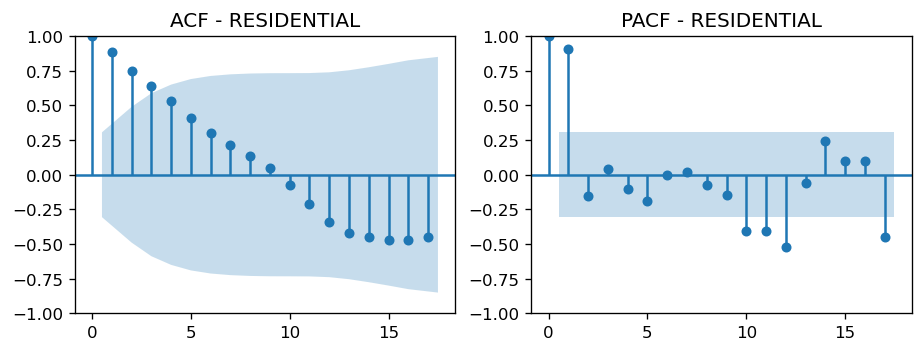

Prueba de estacionariedad con d=0:
Results of Dickey-Fuller Test:
Test Statistic                  1.707679
p-value                         0.998147
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Prueba de estacionariedad con d=1:
Results of Dickey-Fuller Test:
Test Statistic                -5.728469e+00
p-value                        6.685505e-07
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64
Prueba de estacionariedad con d=2:
Results of Dickey-Fuller Test:
Test Statistic                 -0.719317
p-value                         0.841682
#Lags Used                      6.000000
Number of Observations Used    43.000000
Critical Valu

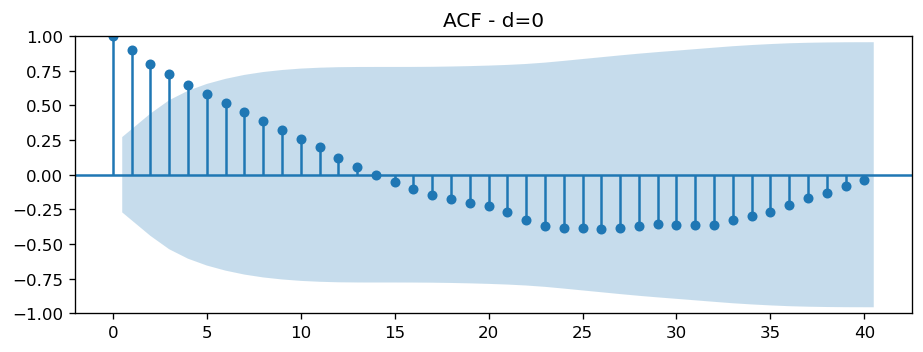

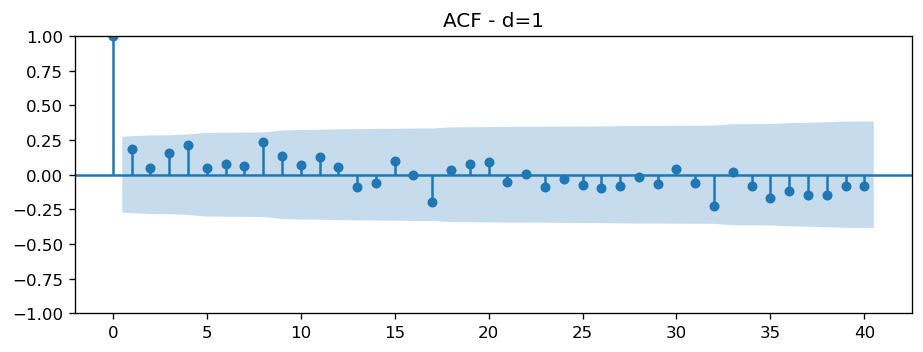

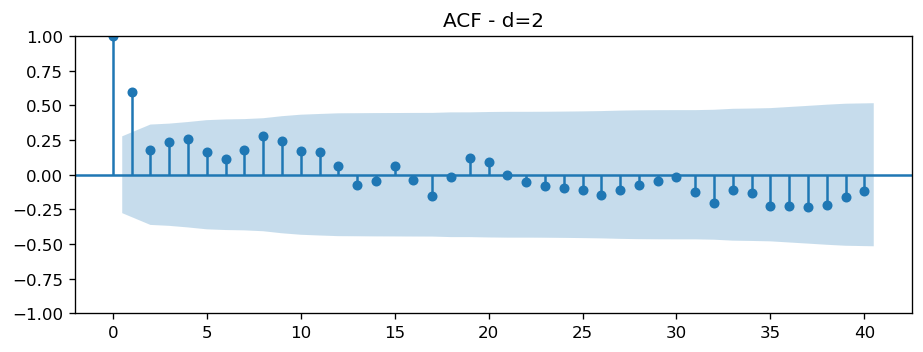

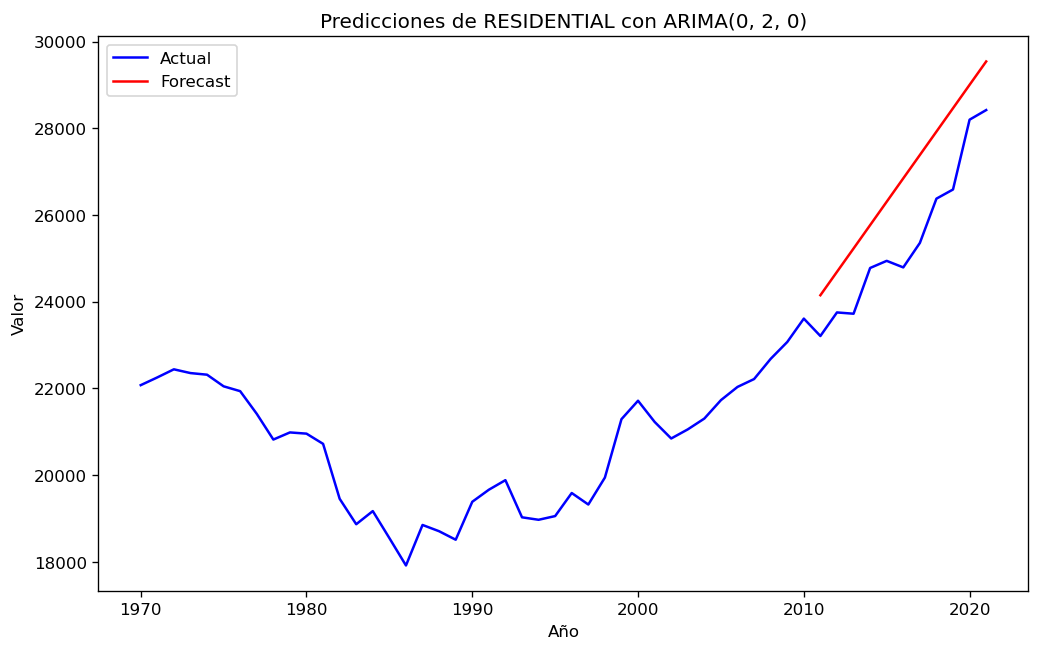



Variable: COMMERCIAL, SERVICES, PUBLIC
Prueba de estacionariedad:
Results of Dickey-Fuller Test:
Test Statistic                  1.864654
p-value                         0.998469
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


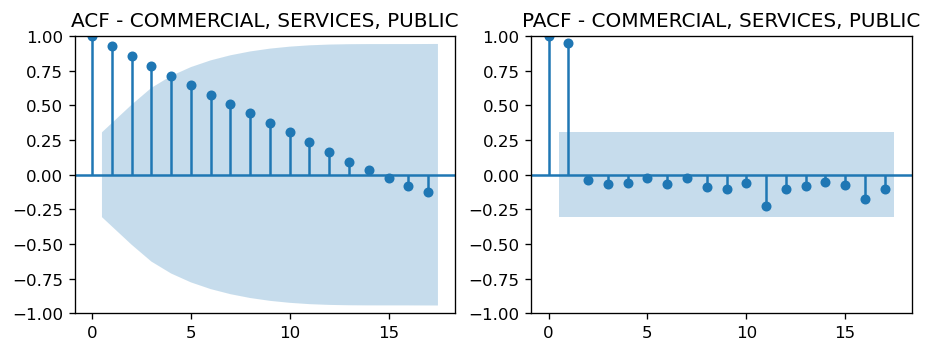

Prueba de estacionariedad con d=0:
Results of Dickey-Fuller Test:
Test Statistic                  0.096022
p-value                         0.965788
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Prueba de estacionariedad con d=1:
Results of Dickey-Fuller Test:
Test Statistic                -7.132217e+00
p-value                        3.493917e-10
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64
Prueba de estacionariedad con d=2:
Results of Dickey-Fuller Test:
Test Statistic                 -3.301062
p-value                         0.014831
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Valu

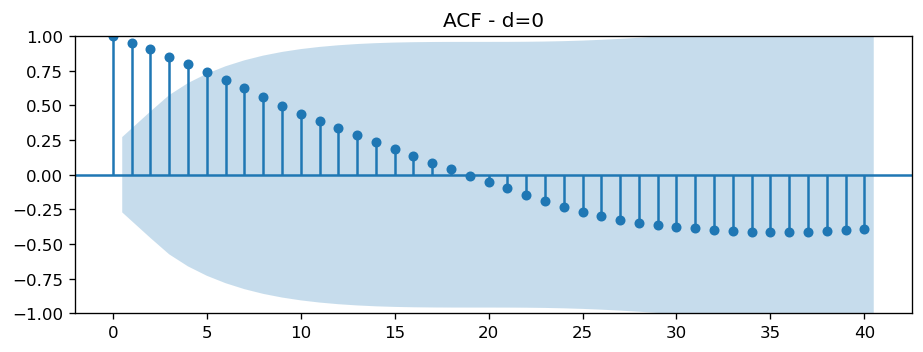

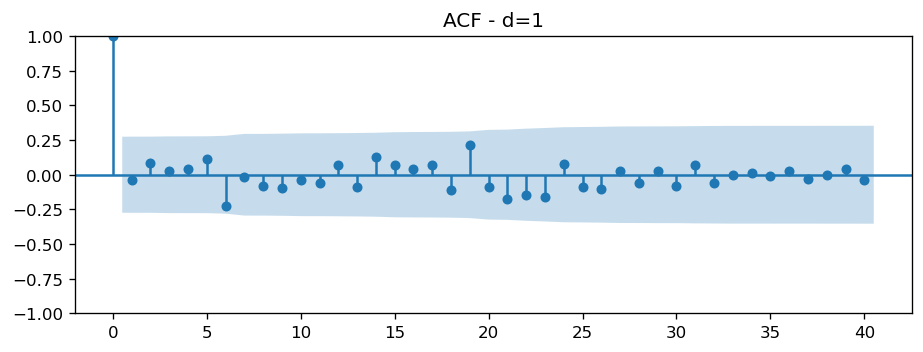

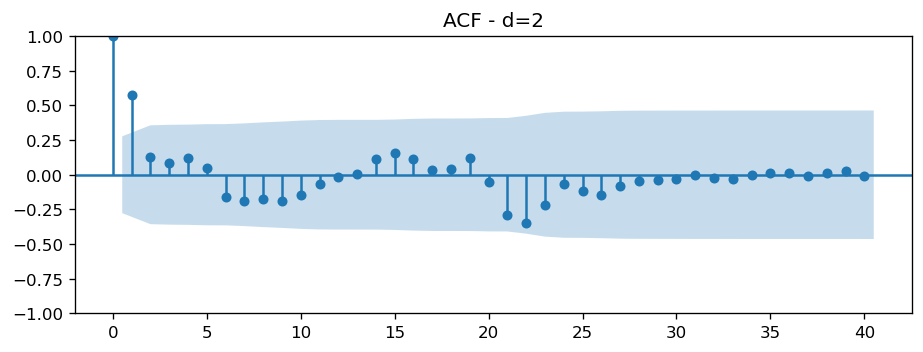

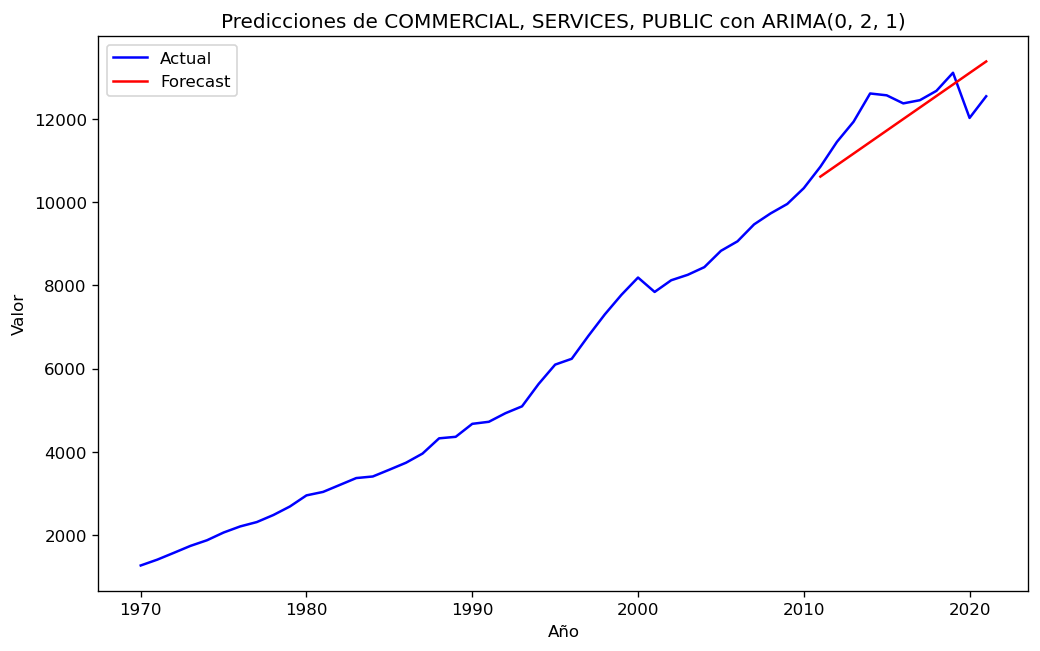



Variable: AGRICULTURE, FISHING AND MINING
Prueba de estacionariedad:
Results of Dickey-Fuller Test:
Test Statistic                  3.883153
p-value                         1.000000
#Lags Used                      8.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


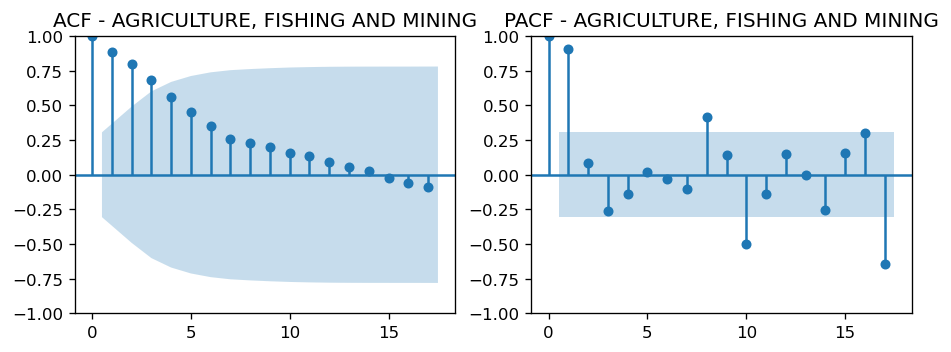

Prueba de estacionariedad con d=0:
Results of Dickey-Fuller Test:
Test Statistic                  0.578046
p-value                         0.987062
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Prueba de estacionariedad con d=1:
Results of Dickey-Fuller Test:
Test Statistic                -7.836488e+00
p-value                        6.095634e-12
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64
Prueba de estacionariedad con d=2:
Results of Dickey-Fuller Test:
Test Statistic                 -3.341499
p-value                         0.013122
#Lags Used                      3.000000
Number of Observations Used    46.000000
Critical Valu

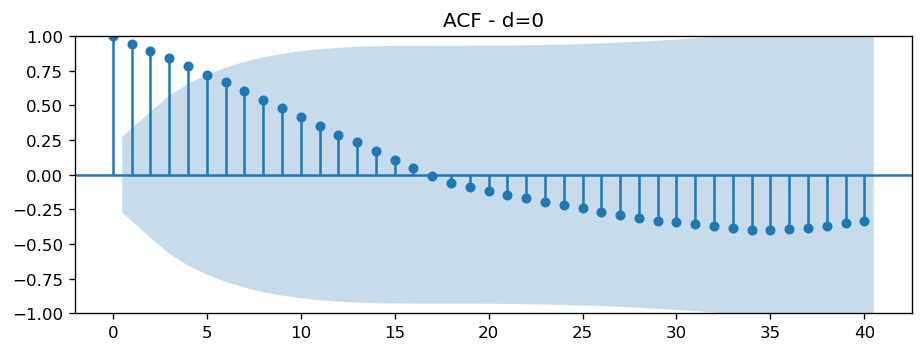

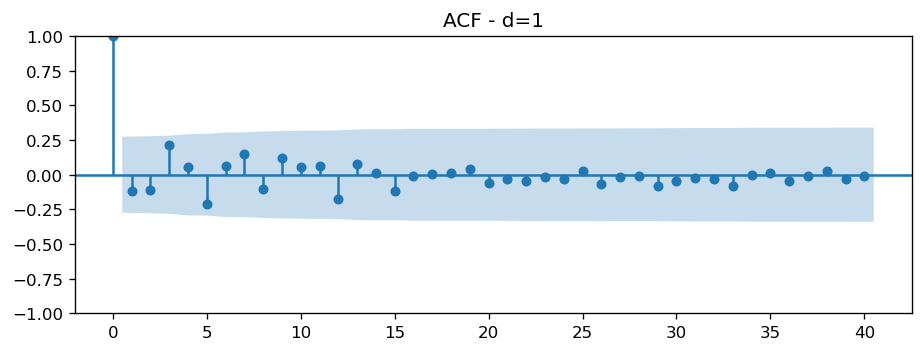

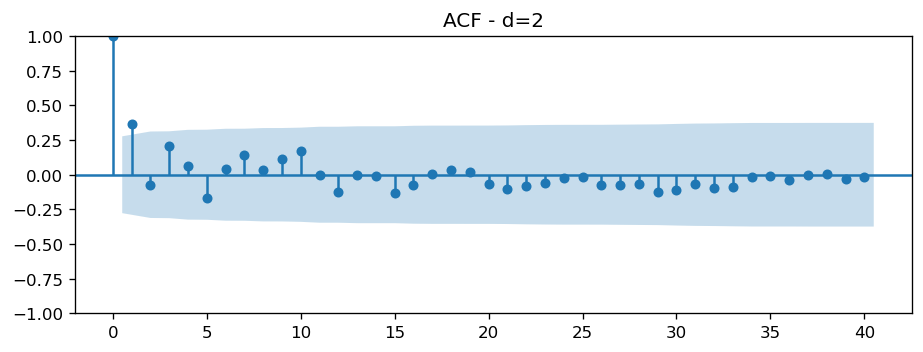

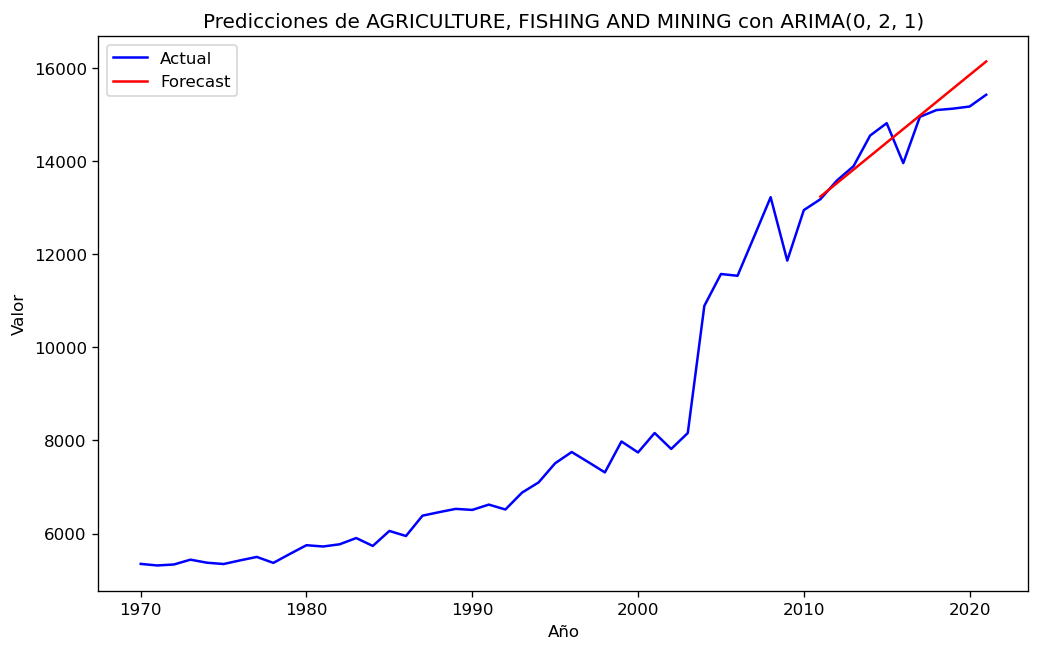



Variable: CONSTRUCTION AND OTHERS
Prueba de estacionariedad:
Results of Dickey-Fuller Test:
Test Statistic                -5.674957e+00
p-value                        8.747808e-07
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+01
Critical Value (1%)           -3.605565e+00
Critical Value (5%)           -2.937069e+00
Critical Value (10%)          -2.606986e+00
dtype: float64


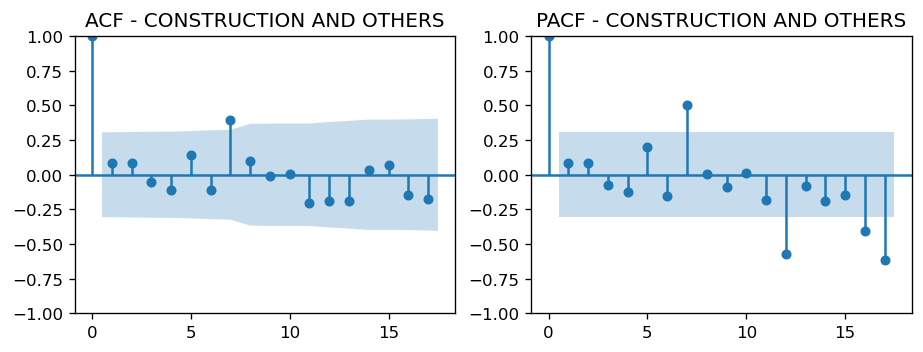

Prueba de estacionariedad con d=0:
Results of Dickey-Fuller Test:
Test Statistic                -6.190675e+00
p-value                        6.133838e-08
#Lags Used                     0.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64
Prueba de estacionariedad con d=1:
Results of Dickey-Fuller Test:
Test Statistic                -6.367267e+00
p-value                        2.392769e-08
#Lags Used                     5.000000e+00
Number of Observations Used    4.500000e+01
Critical Value (1%)           -3.584829e+00
Critical Value (5%)           -2.928299e+00
Critical Value (10%)          -2.602344e+00
dtype: float64
Prueba de estacionariedad con d=2:
Results of Dickey-Fuller Test:
Test Statistic                 -3.675796
p-value                         0.004467
#Lags Used                      7.000000
Number of Observations Used    42

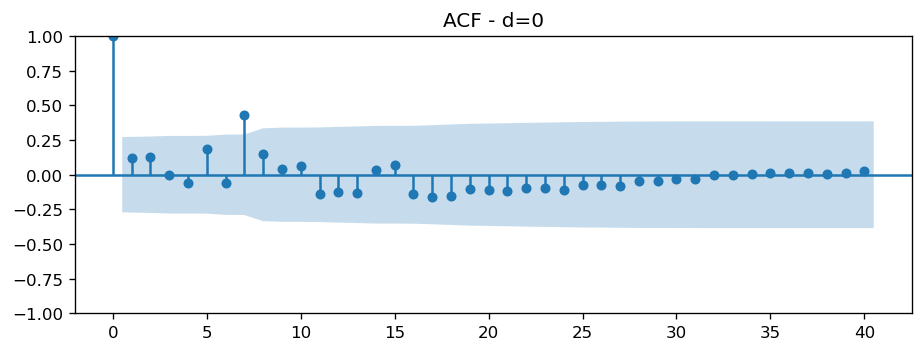

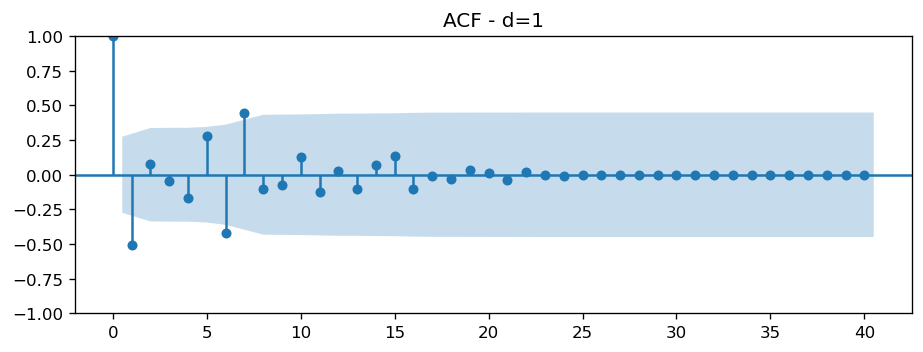

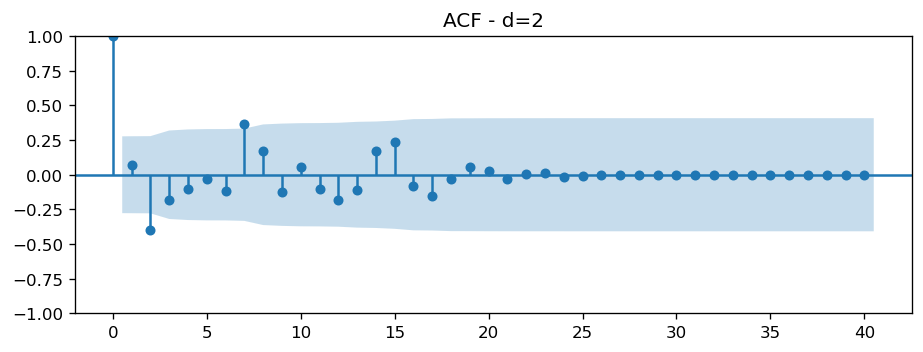

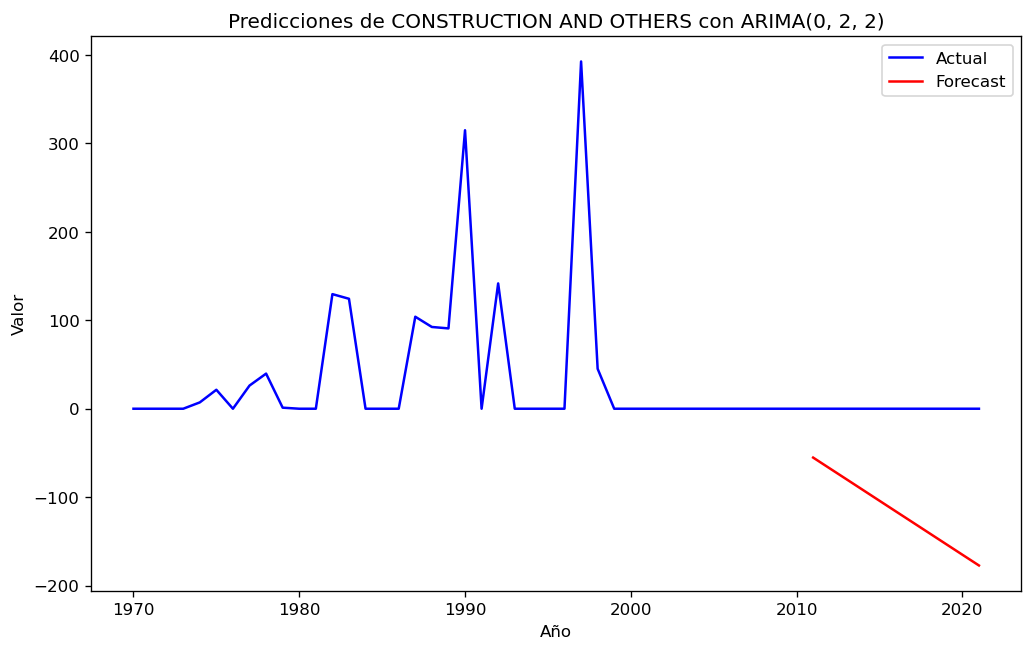



Variable: NON-ENERGY CONSUMPTION
Prueba de estacionariedad:
Results of Dickey-Fuller Test:
Test Statistic                 -1.914423
p-value                         0.325307
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


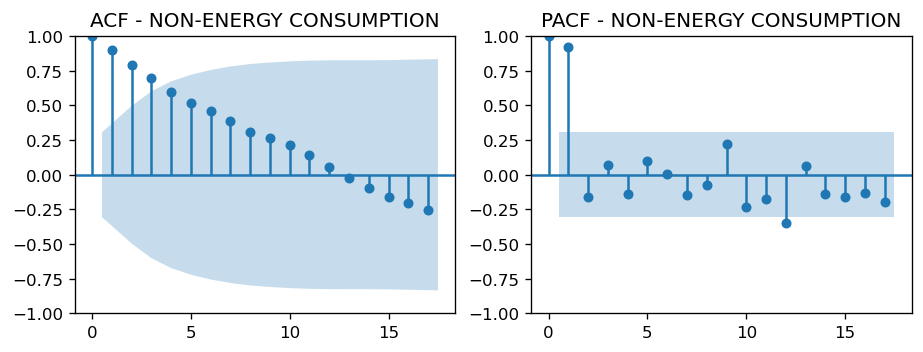

Prueba de estacionariedad con d=0:
Results of Dickey-Fuller Test:
Test Statistic                 -2.312696
p-value                         0.167906
#Lags Used                     10.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64
Prueba de estacionariedad con d=1:
Results of Dickey-Fuller Test:
Test Statistic                 -4.451712
p-value                         0.000240
#Lags Used                      9.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64
Prueba de estacionariedad con d=2:
Results of Dickey-Fuller Test:
Test Statistic                 -2.213042
p-value                         0.201546
#Lags Used                     10.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.

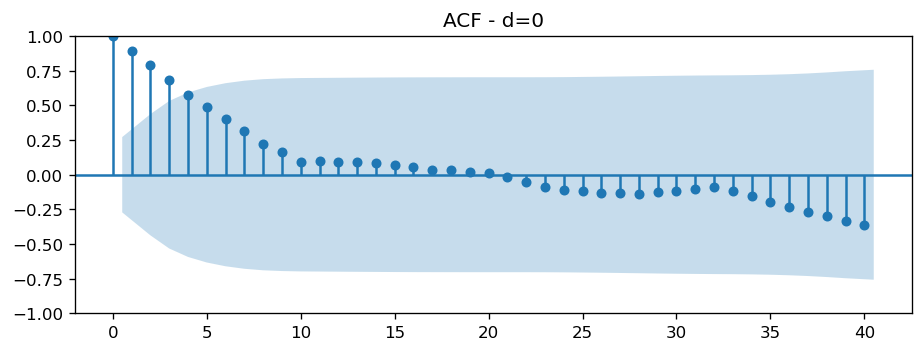

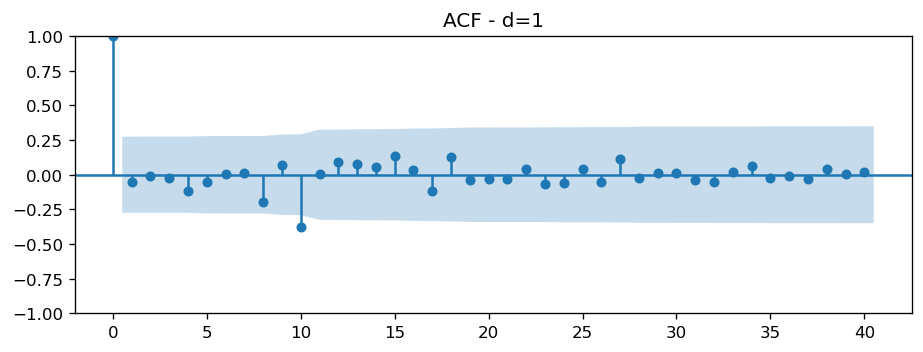

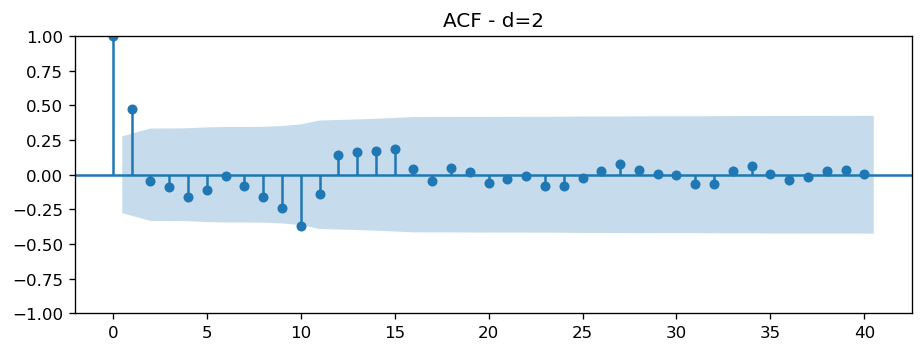

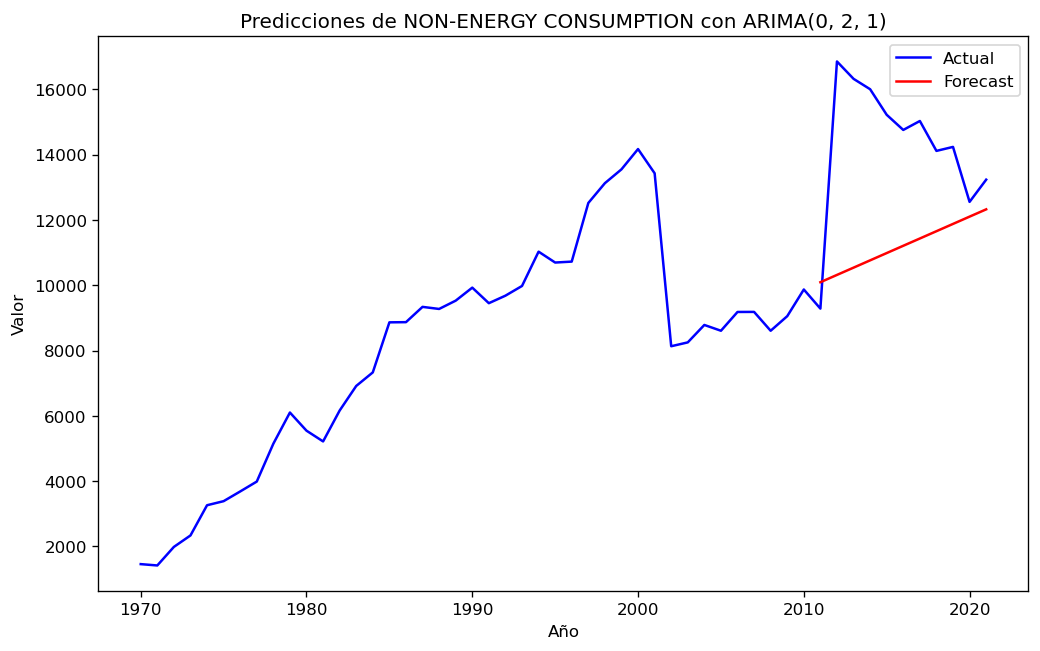



Variable: FINAL CONSUMPTION
Prueba de estacionariedad:
Results of Dickey-Fuller Test:
Test Statistic                  2.642867
p-value                         0.999082
#Lags Used                      7.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


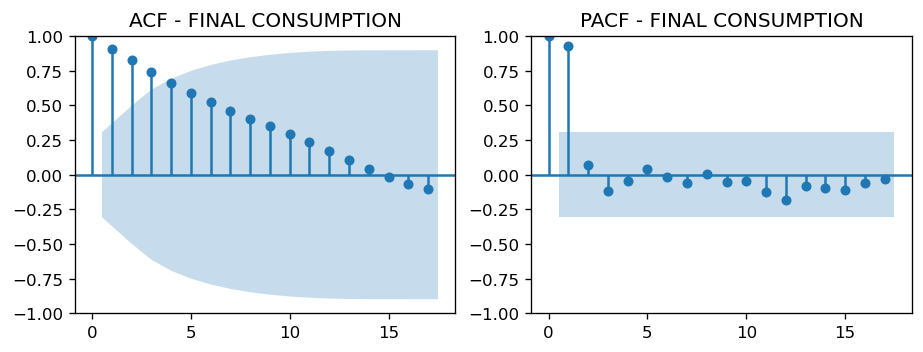

Prueba de estacionariedad con d=0:
Results of Dickey-Fuller Test:
Test Statistic                  0.030940
p-value                         0.961017
#Lags Used                      0.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64
Prueba de estacionariedad con d=1:
Results of Dickey-Fuller Test:
Test Statistic                 -3.526399
p-value                         0.007334
#Lags Used                      1.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64
Prueba de estacionariedad con d=2:
Results of Dickey-Fuller Test:
Test Statistic                 -3.840343
p-value                         0.002521
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.

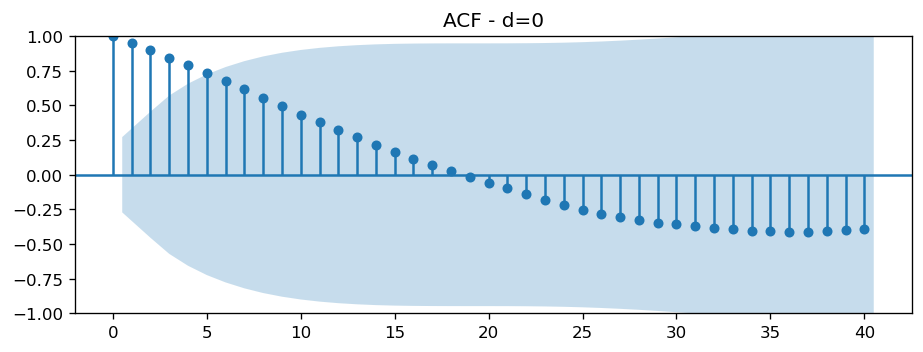

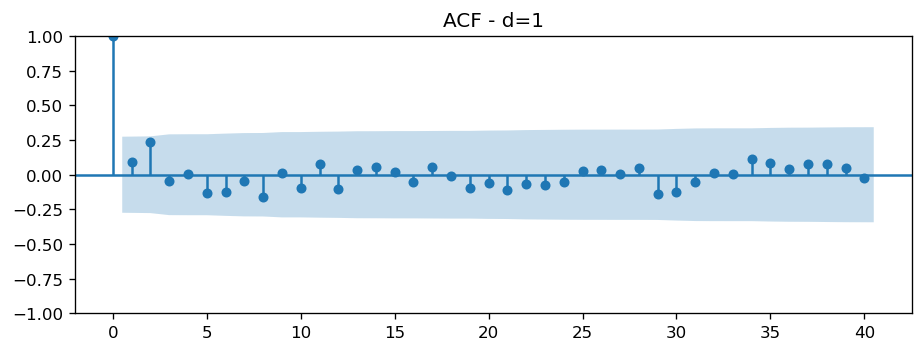

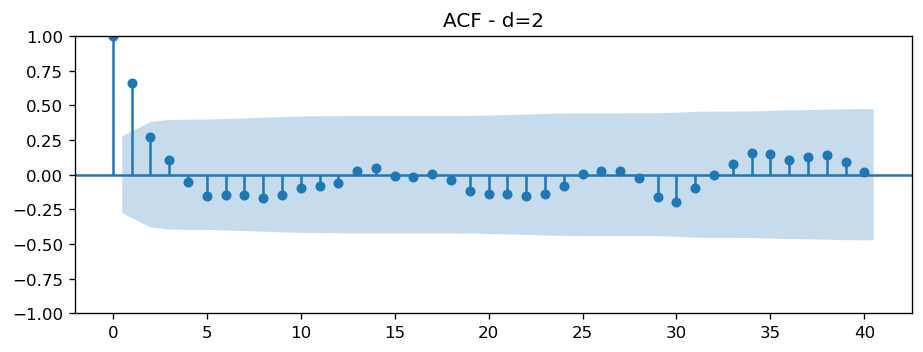

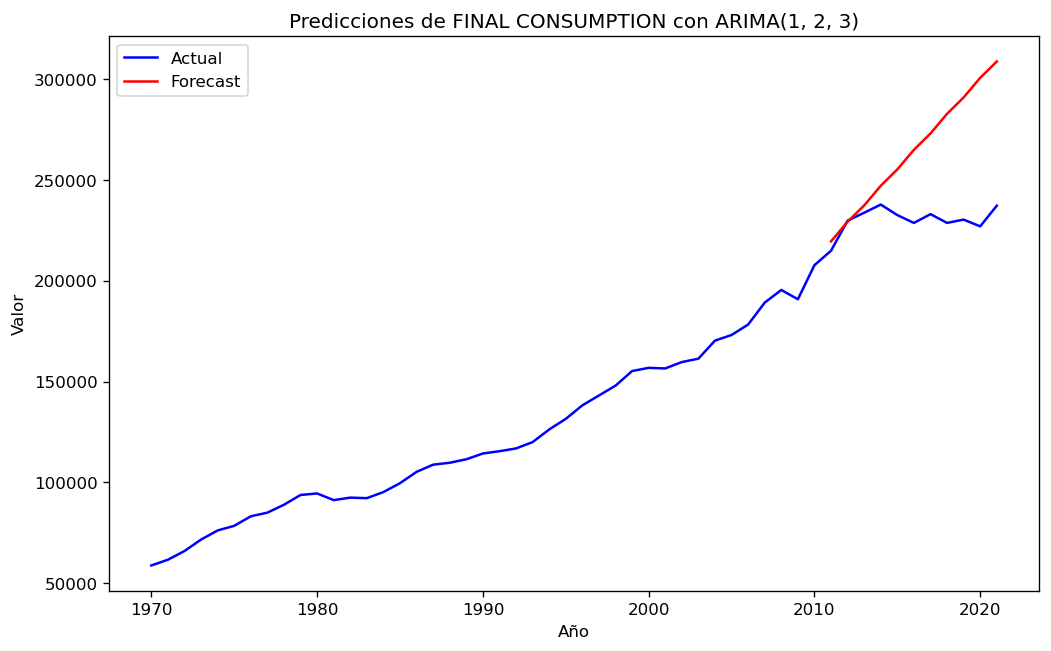

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

variables = ['INDUSTRIAL', 'RESIDENTIAL', 'COMMERCIAL, SERVICES, PUBLIC',
             'AGRICULTURE, FISHING AND MINING', 'CONSTRUCTION AND OTHERS',
             'NON-ENERGY CONSUMPTION', 'FINAL CONSUMPTION']

# Ciclo para analizar cada variable
for variable in variables:
    print(f"Variable: {variable}")
    
    # Dividir los datos en entrenamiento y prueba
    train_start = '1970'
    train_end = '2010'
    test_start = '2011'
    test_end = '2021'
    
    df_variable = df_C[[variable]]
    df_variable.index = pd.to_datetime(df_variable.index, format='%Y')
    
    df_train = df_variable[train_start:train_end]
    df_test = df_variable[test_start:test_end]
    
    # Función para probar la estacionariedad
    def test_stationarity(timeseries):
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    
    # Accuracy metrics
    def forecast_accuracy(forecast, actual):
        mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
        return mape
    
    # Probar la estacionariedad de la serie
    print("Prueba de estacionariedad:")
    test_stationarity(df_train)
    
    # Visualizar la función de autocorrelación parcial
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plot_acf(df_train, ax=plt.gca(), title=f'ACF - {variable}')
    plt.subplot(1, 2, 2)
    plot_pacf(df_train, ax=plt.gca(), title=f'PACF - {variable}')
    plt.show()
    
    # Encontrar el orden de diferenciación "d"
    d = 0  # Inicialmente, no aplicamos diferenciación

    while True:
        if d == 0:
            df_diff = df_variable
        else:
            df_diff = df_variable.diff(periods=d).dropna()

        # Prueba de estacionariedad
        print(f"Prueba de estacionariedad con d={d}:")
        test_stationarity(df_diff)

        # Calcular las autocorrelaciones ACF
        acf_plot = plot_acf(df_diff, lags=min(40, len(df_diff) - 1), title=f'ACF - d={d}')


        # Contar cuántas autocorrelaciones son positivas
        acf_values = acf(df_diff, nlags=min(40, len(df_diff) - 1), fft=False)

        positive_acf_count = sum(acf_values[1:] > 0)


        if positive_acf_count <= 10 or d == 2:
            break

        d += 1

    print(f"Valor óptimo de d: {d}")
    
    # Encontrar el mejor modelo ARIMA
    best_aic = np.inf
    best_order = None
    
    for p in range(5):  # Prueba con órdenes p de 0 a 4
        for q in range(5):  # Prueba con órdenes q de 0 a 4
            try:
                model = ARIMA(df_train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
            except:
                continue
    
    print(f"Mejor modelo ARIMA({best_order[0]}, {best_order[1]}, {best_order[2]}) con AIC={best_aic}")
    
    # Ajustar el modelo ARIMA seleccionado
    model = ARIMA(df_train, order=best_order)
    model_fit = model.fit()
    
    # primir el resumen del modelo
    print(model_fit.summary())
    
    # Prediction
    forecast_val = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
    
    # Crear un DataFrame con las predicciones y establecer el índice
    df_forecast = pd.DataFrame(data=forecast_val, index=df_test.index)
    
     # Calcular la precisión de pronóstico
    mape = forecast_accuracy(df_forecast, df_test)
    mape_value = mape.iloc[0] * 100  # Acceder al valor del MAPE
    print(f"Precisión de pronóstico (MAPE): {mape_value:.2f}%")

    # Create a Pandas DataFrame with the forecasted values and set the index
    df_forecast = pd.DataFrame(data=forecast_val, index=df_test.index)

    # Calcular la precisión de pronóstico
    mse = mean_squared_error(df_test, df_forecast)
    r2 = r2_score(df_test, df_forecast)
    
    print(f"Precisión de pronóstico (MSE): {mse:.2f}")
    print(f"Precisión de pronóstico (R^2): {r2:.2f}")

    # Visualizar las predicciones y los datos reales
    plt.figure(figsize=(10, 6))
    plt.plot(df_variable, "b", label="Actual")
    plt.plot(df_forecast, "r", label="Forecast")
    plt.title(f"Predicciones de {variable} con ARIMA({best_order[0]}, {best_order[1]}, {best_order[2]})")
    plt.xlabel("Año")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
    print("\n" + "="*50 + "\n")











### Future forecast (20 more years)

In [406]:
eval_model(model,df_tr,df_val, name="Model",lags=12)

AttributeError: 'ARIMA' object has no attribute 'resid'

## How to do Auto Arima Forecast in Python

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [ ]:
scaled_df.columns

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df= df_transport

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [ ]:
forecast_accuracy()

In [ ]:
# Forecast
n_periods = 20 #years
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df), len(df)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast AGRICULTURE, FISHING AND MINING ")
plt.show()


In [ ]:
scaled_df['forecast'] = [None]*len(train_cur) + list(fc)

scaled_df[['AGRICULTURE, FISHING AND MINING','forecast']].plot()

In [ ]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def Execute_model(model_name,test,train, X_train, X_test, y_train, y_test, FEATURES, target):
    if model_name in ["ARIMA","SARIMA", "ETS"]:
        # Initialize the model with appropriate parameters
        if model_name == "ARIMA":
            model = ARIMA(endog=y_train, order=(5, 1, 0))
        
        if model_name == "SARIMA":
            model = SARIMAX(endog=y_train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
        elif model_name == "ETS":
            model = ExponentialSmoothing(endog=y_train, seasonal='add', seasonal_periods=12)
            
        # Fit the model
        fit_model = model.fit()
        y_pred = fit_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

    if model_name in ["LSTM", "GRU", "CNNs"]:
        # Create and compile the deep learning models
        model = Sequential()

        if model_name == "LSTM":
            model.add(LSTM(50, input_shape=(len(FEATURES), 1), return_sequences=True))
            model.add(Dropout(0.2))
            model.add(LSTM(50, input_shape=(len(FEATURES), 1), return_sequences=True))
            model.add(Dropout(0.2))
            model.add(LSTM(50, return_sequences=False))  # Add another LSTM layer with return_sequences=True
            model.add(Dense(1))
        elif model_name == "GRU":
            model.add(GRU(50, input_shape=(len(FEATURES), 1), return_sequences=True))
            model.add(Dropout(0.2))
            model.add(GRU(50, input_shape=(len(FEATURES), 1), return_sequences=True))
            model.add(Dropout(0.2))
            model.add(GRU(50, input_shape=(len(FEATURES), 1), return_sequences=False))
     
            model.add(Dense(1))
        elif model_name == "CNNs":
            model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
            model.add(Dropout(0.2))  # Agregar dropout para evitar overfitting
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1, activation='linear'))
        #elif model_name == "CNN":
         #   model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(len(FEATURES), 1)))
          #  model.add(MaxPooling1D(pool_size=2))
           # model.add(Flatten())

        
        model.compile(optimizer='adam', loss='mse')

        # Convert data types to float64
        X_train = X_train.values.astype('float64')
        X_test = X_test.values.astype('float64')

        # Reshape input data for deep learning models
        X_train = X_train.reshape((-1, len(FEATURES), 1))
        X_test = X_test.reshape((-1, len(FEATURES), 1))

        # Ensure y_train and y_test are float64
        y_train = y_train.astype('float64')
        y_test = y_test.astype('float64')

        # Fit the model
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        # Make predictions
        y_pred = model.predict(X_test).flatten()

    # Calculate mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #rmse= sqrt(abs(y_test-y_predic))
    
    # Calculate R-squared (Coefficient of Determination)
    r2 = r2_score(y_test, y_pred)
    # Define the Plot function within Execute_model
    def Plot(train=train, test=test,X_test=X_test, y_test=y_test, y_pred=y_pred):
        combined_index = np.concatenate((train.index, test.index), axis=0)
        combined_y_pred = np.concatenate((y_train, y_pred), axis=0)
        combined_y_test = np.concatenate((y_train, y_test), axis=0)
        
        plt.figure(figsize=(10, 6))
        
        plt.plot(combined_index, combined_y_pred, label='Predicted')
        plt.plot(combined_index, combined_y_test, label='Actual')
        plt.title(f'Actual and Predicted data of model {model_name} with rmse={rmse:.2f}, R-squared={r2:.2f}')
        plt.xlabel("Year")
        plt.ylabel(target)
        plt.legend()
        plt.grid(True)
        plt.show()
 
    # Call the Plot function
    #Plot(X_test, y_test, y_pred)

  
    results={"model_name":model_name, "rmse":rmse, "y_pred":y_pred, "R-squared": r2, "Plot": Plot()}
    
    return results


In [ ]:
columns=["SECTOR", "model_name", "RMSE"]
df_BEST_MODELS=pd.DataFrame(columns= columns)
for target in SECTORS: 
    
    # Split data into train and test sets 
    train_size = int(len(scaled_df) * 0.80)
    train, test = scaled_df.iloc[:train_size], scaled_df.iloc[train_size:]  
    X_train = train[FEATURES]
    X_test = test[FEATURES]
    y_train = train[target]   
    y_test = test[target]
    
    models=["ARIMA","SARIMA", "ETS","LSTM", "GRU","CNNs"]
    results=[]
    for model_name in models:
        res=Execute_model(model_name=model_name,test=test,train=train, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, FEATURES=FEATURES, target=target)
    
        results.append(res)
    
    #best_accuracy=max(result['Accuracy'] for result in results)
    min_rmse = min(result['rmse'] for result in results)
    best_model = next(result['model_name'] for result in results if result['rmse'] == min_rmse)   
    result_dict = {'SECTOR': target, 'model_name': best_model, 'RMSE': f"{min_rmse:.2f}"}
    df_BEST_MODELS = pd.concat([df_BEST_MODELS, pd.DataFrame([result_dict])], ignore_index=True)
    
    

    

In [ ]:
df_BEST_MODELS

# Predict for 20 more years:

Use the best model for each sector to predict then sum the values of all sectors to obtain the final consumption. We will do step by step as folowing:

### Step 1: Extend the time series data for 20 more years
Creating the extended data when it will happen in the future might involve a different approach compared to creating it with historical data. In this case, you won't have the actual future values to include in your extended data.

One approach is to make use of the predictions from your selected best models to generate a forecast for the next 20 years. 

In [ ]:
# Create an extended DataFrame to store the forecasted data
extended_data = scaled_df.copy()
extended_data.tail()

In [ ]:
extended_data.columns[-6:]

In [ ]:
# Step 1: Extend the time series data for 20 more years
extended_years = 20
extended_data = ...  # Create a new DataFrame with 20 more years of data

# Step 2: Retrieve Best Models for Each Sector
best_models = {}
for target in SECTORS:
    best_model_row = df_BEST_MODELS[df_BEST_MODELS['SECTOR'] == target].iloc[0]
    best_models[target] = best_model_row['model_name']

# Step 3: Retrain Best Models with Extended Data
extended_results = {}
for target, best_model_name in best_models.items():
    train_size = int(len(scaled_df) * 0.80)
    train, _ = scaled_df.iloc[:train_size], scaled_df
    X_train = train[FEATURES]
    y_train = train[target]

    # Retrain the best model using the extended data
    extended_X_train = extended_data[FEATURES]
    extended_y_train = extended_data[target]
    extended_result = Execute_model_with_optimization(extended_data, train, extended_X_train, extended_X_train, extended_y_train, extended_y_train, FEATURES, target)
    extended_results[target] = extended_result

# Step 4: Make Predictions for Extended Period
for target, result in extended_results.items():
    best_model = best_models[target]
    best_model_name = result['model_name']
    best_model_rmse = result['rmse']
    extended_y_pred = result['y_pred']

    # Print or process the extended predictions for the next 20 years
    print(f"Predictions for {target} using {best_model_name} (RMSE: {best_model_rmse:.2f}):")
    print(extended_y_pred)